# ANLP 2020 - Assignment 4


*Sophia Student, 1234567* (enter your name/student id number here)

<div class="alert alert-block alert-danger">Due: Wednesday, February 3rd 2021</div>

<div class="alert alert-block alert-info">

**NOTE**<br><br>

Please first fill in your name and id number at the top of the assignment, and **rename** the assignment file to **yourlastname-anlp-4.ipynb**<br><br>
Problems and questions are given in blue boxes like this one. All grey and white boxes must be filled by you (they either require code or a (brief!) discussion). <br><br>
Please hand in your assignment by the deadline via Moodle upload (we will provide a link). In case of questions, you can contact us via email, or via the Piazza (preferred).

</div>

## Structural ambiguity [20 pts]

<div class="alert alert-block alert-info">
    
Devise at least two sentences that exhibit structural ambiguity (i.e., ambiguity that comes from different structural analyses, not from ambiguity in the meaning of an individual lexical item). Indicate the different analyses (at least two per sentence) with a syntactic tree.

You can draw trees by using the NLTK package:

</div>

In [2]:
from nltk.tree import Tree
import nltk
import pandas as pd
import numpy as np
nltk.download('large_grammars')
import configparser


[nltk_data] Downloading package large_grammars to /home/local/MPIB-
[nltk_data]     BERLIN/raza/nltk_data...
[nltk_data]   Package large_grammars is already up-to-date!


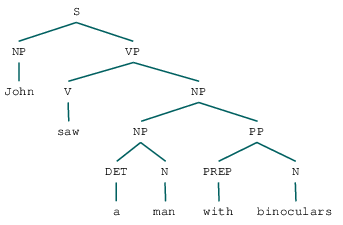

In [84]:
sentence1 = '(S (NP John) (VP (V saw) (NP (NP (DET a ) (N man))    (PP (PREP with) (N binoculars) ))) )'
Tree.fromstring(sentence1)

*This sentence means, John saw a man and that man was carrying binoculars.*

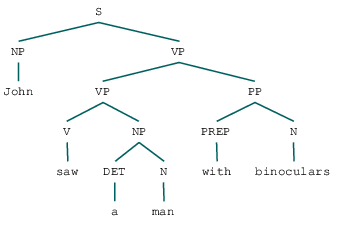

In [86]:
sentence1_bis = '(S (NP John) (VP (VP (V saw)( NP (DET a ) (N man)))   (PP (PREP with) (N binoculars) )))'
Tree.fromstring(sentence1_bis)

*This means that John used binoculars to see a man*

#### 2nd Example

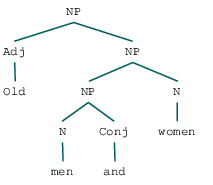

In [90]:
s3 = "(NP (Adj Old) (NP (NP (N men) (Conj and)) (N women) ))"
Tree.fromstring(s3)

*This is equivalent to old (men and women). Which means both men and women are old.*

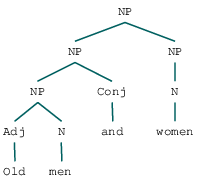

In [92]:
s3 = "(NP (NP (NP (Adj Old) (N men)) (Conj and)) (NP (N women)))"
Tree.fromstring(s3)

*This sentence is equivalent to (Old men) and women. This describe only men as old.*

#### 3rd Example

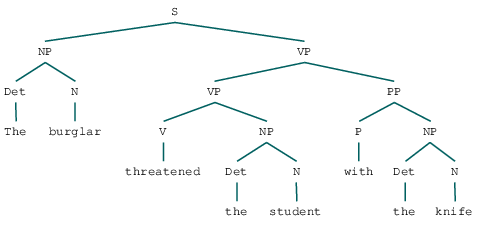

In [87]:
s2 = '(S (NP (Det The) (N burglar)) (VP (VP (V threatened) (NP (Det the) (N student))) (PP (P with) (NP (Det the) (N knife)))))'
Tree.fromstring(s2)

*This sentences means the burglars who does the threatening has the knife*

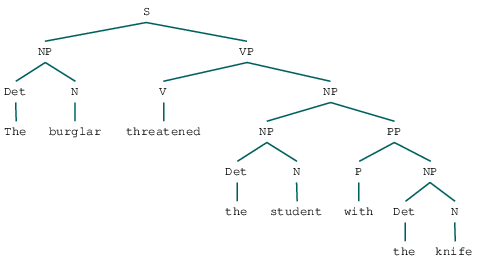

In [88]:
s2 = '(S (NP (Det The) (N burglar)) (VP (V threatened) (NP (NP (Det the) (N student)) (PP (P with) (NP (Det the) (N knife))))))'
Tree.fromstring(s2)

*The above sentence indicate that the burglar threatens a student and the student is the one carrying the knife*

## CKY Parsing. Some Notes

<div class="alert alert-block alert-info">
    
In this assignment, you will implement the CKY algorithm for English and apply it to the word recognition and parsing problem. You can use the NLTK modules for representing context-free grammars and parse trees, but you should implement the parser from scratch. (But you don't *have* to use `nltk.grammar` if you find it easier without. Some NLTK modules are overly complicated, and in this assignment you mainly need a lookup function from right-hand-sides of grammar rules to left-hand-sides.)<br><br>

We provide the grammar and the test sentences.
The grammar stems from the Airline Travel Information System (ATIS), a project working on spoken dialog systems for air travel. (What do you think, is this a grammar motivated by syntactic theory, or perhaps more motivated by other concerns? Does it look like the sample grammars we've seen in class, only larger, or does it fundamentally look different?) The ATIS CFG is available in the NLTK data package, together with 98 test sentences. You can initialize the resources this way:

</div>

In [4]:
# load the grammar
grammar = nltk.data.load("grammars/large_grammars/atis.cfg")
# load the raw sentences
s = nltk.data.load("grammars/large_grammars/atis_sentences.txt", "auto")
# extract the test sentences
t = nltk.parse.util.extract_test_sentences(s)

<div class="alert alert-block alert-info">
    
NLTK already implements a number of parsing algorithms (see `nltk.parse` for the list). You can try one to see if you loaded the grammar correctly.<br><br>
Note that NLTK's `chart_parse()` throws an error when it encounters an unknown word, which is undesirable behavior for any parser. If you want to test the grammars with the pre-implemented parser (for example, to check whether the CNF version is in fact weakly equivalent), you may need to catch this error.

</div>

In [5]:
# initialize the parser
parser = nltk.parse.BottomUpChartParser(grammar)
# parse all test sentences
for sentence in t[:10]:
    parser.chart_parse(sentence[0])

<div class="alert alert-block alert-info">
    
However, the NLTK version of the ATIS grammar is not in Chomsky normal form (CNF), which you will need for your CKY parser. Feel free to implement a conversion module for extra credit, but for your convenience, we have already converted the ATIS CFG into CNF, provided with this assignment. You can then read the grammar from the file using `nltk.data.load()` and utilize the features of the `nltk.grammar` module on the resulting object.

</div>

### Problem 1: Word Recognition [50 pts]

<div class="alert alert-block alert-info">

Implement the CKY algorithm and use it as a recognizer. That is, given an input sentence, the procedure should decide whether the sentence is in the language of the CFG or not. 

</div>

In [3]:
df = pd.read_csv("dataset/atis-grammar-cnf.cfg", sep = '-> ', header= None, names= ['A', 'B'])
df.head()

,A,B
0,SIGMA,ADJ_ABL JYL
1,GCC,AVP_RB GCD
2,GCD,NP_DTS pt_char_per
3,GCA,AVP_RB GCB
4,GCB,COMPCL_VBZ pt_char_per


In [4]:
df['A'] = df['A'].apply(lambda x: x[:-1])
df['B'] = df['B'].apply(lambda x: x[1:-1] if x[0]=='"' else x)

In [5]:
def lookup(aa,bb):
    aa = aa.split()
    bb = bb.split()
    idx = []
    for a in aa:
        for b in bb:
            look = a+" "+b
            idx += df[df['B'] == look]['A'].tolist()
    return idx

In [34]:
# your code goes here
def cky(sentence, df= df):
    words = sentence.split()
    n = len(words)
    chart = np.zeros((n+2,n+2), dtype = "object")
    chart[:,:] = ""
    val = []

    #Initial Diagonals
    for i, w in enumerate(words):
        idx = df[df['B'] == w]['A'].tolist()
        chart[i+1, i+2] = " ".join(idx)
    

    # CKY LOOPS
    for b in range(2, n+1):
        for i in range(1, n-b+2):
            found = []
            for k in range(1,b):
                found += lookup(chart[i,i+k], chart[i+k, i+b])
                if k == b-1:
                    chart[i, i+b] = " ".join(found)
                #chart[i, i+b] = chart[i, i+b] + " " + lookup(chart[i,i+k], chart[i+k, i+b])

    if "SIGMA" in chart[1,n+1].split():
        print("True")
    else:
        print("False")
    return chart

<div class="alert alert-block alert-info">

Provide a list of grammatical and ungrammatical test sentences (at least 10 each) and test your recognizer on these sentences. 

</div>

In [68]:
chart = cky("show availability .")

True


In [61]:
chart = cky("flights delay")

False


In [62]:
chart = cky("flight operation .")

True


In [63]:
chart = cky("which flights are cheapest")

False


In [64]:
chart = cky("texas to newyork")

False


In [65]:
chart = cky("flight to cleveland .")

True


In [70]:
chart = cky("what is the fare .")

True


In [66]:
chart = cky("prepare for takeoff")

False


In [67]:
chart = cky("flgiht delayed")

False


In [72]:
chart = cky("flight was good")

False


*Ungrammatical Sentences*

In [71]:
chart = cky("fine is not")

False


In [73]:
chart = cky("not cheap fare")

True


In [74]:
chart = cky("I fly have to today")

False


In [75]:
chart = cky("good not flight")

False


In [76]:
chart = cky("long is flight")

False


In [77]:
chart = cky("book to like")

False


In [78]:
chart = cky("i buy like flight")

False


In [79]:
chart = cky("Exit is .")

False


In [80]:
chart = cky("departure out good .")

False


In [81]:
chart = cky("rain flight delay caused")

False


The code is pretty simple, we try to fill up the diagonals of an array with non-terminals. The First diagonals just consist of converting the terminals of a sentence input to non-terminals. The second diagonals take cumulative input of set of 2 words converted to non-terminals to produce corresponding non-terminal. This way we cover the whole sentence and at the end, we can tell whether this sentence can be made using grammer or not or in other words, If this sentence correct given the context free grammer.

### Problem 2: Parsing [30 pts]

<div class="alert alert-block alert-info">

Now extend your CKY recognizer into a parser by adding backpointers. Also implement a function that extracts the set of all parse trees from the backpointers in the chart. Feel free to use the NLTK module `nltk.tree` for this purpose; notice that only `ImmutableTree`s can be used as elements of Python sets, whereas raw `Tree`s cannot.

</div>

In [17]:
a = []
if a == []:
    print("yes")

yes


In [44]:
def lookup_back(aa,bb, lst, p, q, m):
    aa = aa.split()
    bb = bb.split()
    idx = []
    for a in aa:
        for b in bb:
            look = a+" "+b
            f = df[df['B'] == look]['A'].tolist()
            idx += f
            if len(f) > 0:
                lst[p][q].append((a,b,(p,m), (m,q),f))
    return idx, lst

In [47]:
# your code goes here
def cky_back(sentence, df= df):
    words = sentence.split()
    n = len(words)
    chart = np.zeros((n+2,n+2), dtype = "object")
    lst = [[[] for i in range(n+2)] for j in range(n+2)]
    chart[:,:] = ""
    val = []

    #Initial Diagonals
    for i, w in enumerate(words):
        idx = df[df['B'] == w]['A'].tolist()
        chart[i+1, i+2] = " ".join(idx)
        lst[i+1][i+2]= (w, 0, (0,0), (0,0), idx)
    

    # CKY LOOPS
    for b in range(2, n+1):
        for i in range(1, n-b+2):
            found = []
            for k in range(1,b):
                f, lst = lookup_back(chart[i,i+k], chart[i+k, i+b], lst, i, i+b, i+k)
                found += f
                if k == b-1:
                    chart[i, i+b] = " ".join(found)
                #chart[i, i+b] = chart[i, i+b] + " " + lookup(chart[i,i+k], chart[i+k, i+b])

    #if "SIGMA" in chart[1,n+1].split():
        #print("SENTENCE CAN BE MADE USING VOCABLARY")
    #else:
        #print("Sorry, the sentence cannot be made using this vocablary")
    return lst

In [50]:
# your code goes here
lst = cky_back("show .")

In [57]:
for i in range(len(lst[1][3])):
    print("SIGMA" in lst[1][3][i][-1])

False
True
False
False
False
True


In [ ]:
def find_tree(lst):
    n = len(lst) - 2
    #final = ["SIGMA", [], []]
    r = explore_cell("SIGMA", (1, n+1), lst) 
    # final = [["SIGMA", [], []] for i in range(len(r))]
    # for c, res in enumerate(r):
    #     final[c][1].append(res[0])
    #     final[c][2].append(res[1])
    #     next_left_pos = res[2]
    #     next_right_pos = res[3]

    lst[1][n+1].clear()
    lst[1][n+1].append(("SIGMA", r[0], r[1]))
    left = explore_cell(r[0], next_left_pos, lst)
    lst[next_left_pos[0]][next_left_pos[1]].clear()
    lst[next_left_pos[0]][next_left_pos[1]].append(w, left[0], left[1])





In [59]:
def explore_cell(word, pos, lst):
    result = []
    p = pos[0]
    q = pos[1]
    for i in range(len(lst[p][q])):
        if word in lst[p][q][i][-1]:
            result.append(lst[p][q][i])
    return result

In [ ]:
def find_tree(lst):
    n = len(lst)-2
    key = []
    m = []
    for i,val in enumerate(list(lst[1][n+1].values())):
        if "SIGMA" in val:
            key.append(list(lst[1][n+1].keys())[i]))
            m.append(val[0])
    
    for a,b in zip(key, m):
        


In [ ]:
def check(chart):
    n = chart.shape[0] - 2
    for i in range(2, n+1):
        

In [ ]:
def lookup_back(aa,bb, to_find):
    aa = aa.split()
    bb = bb.split()
    idx = []
    val = []
    for a in aa:
        for b in bb:
            look = a+" "+b
            f = df[df['B'] == look]['A'].tolist()
            if to_find in f: 
                val.append(a)
                val.append(b)
                idx.append((1, i))
                idx.append((i, n+1))


    return idx, lst

<div class="alert alert-block alert-info">

Test the parser by providing the list of ATIS test sentences with tab-separated numbers of parse trees.

</div>

*your code/results go here*

<div class="alert alert-block alert-info">

Choose an ATIS test sentence with a number of parses $p$ such that $1 < p < 5$. Provide pictures of its parses. You can visualize an NLTK tree using its `draw` method. Discuss the structural differences.

</div>

*your code/results go here*

### Extra Credit [10 pts]

<div class="alert alert-block alert-info">

If you still have time left, you can attempt the following project for extra credit. Perhaps it has occurred to you that it is quite wasteful to compute all parse trees just to find out how many parse trees there are. Figure out how to compute the number of parse trees for an entry $A ∈ Ch(i, k)$ from your chart with backpointers, without actually computing these parse trees. Verify that you get the correct results, and compare the efficiency of your new procedure to your earlier solution.

</div>

In [ ]:
# your code goes here